In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nsec.models.dae.convdae import SmallUResNet

In [3]:
import tensorflow_datasets as tfds
from jax.experimental import optix
import jax.numpy as jnp

In [4]:
import haiku as hk

In [5]:
# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [6]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.pad(train_images,((0,0),(2,2),(2,2),(0,0)))/255.

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.pad(test_images, ((0,0),(2,2),(2,2),(0,0)))/255.

In [7]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

In [8]:
batch_size=128
delta = 0.25

def get_batch():
    y = train_images[np.random.choice(len(train_images), batch_size)].astype('float32')
    u = np.random.randn(batch_size, 32,32,1)
    s = delta * np.random.randn(batch_size, 1, 1, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [9]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)
import jax 

In [10]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model.apply(params, state, rng_key, batch['x'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [11]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [12]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 32, 32, 1)), jnp.zeros((1, 1, 1, 1)), is_training=True)
opt_state = optimizer.init(params)
losses = []

In [13]:
for step in range(5000):
    batch = get_batch()
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0222077
100 0.3433955
200 0.27707642
300 0.20222528
400 0.25003514
500 0.21272422
600 0.17217602
700 0.1783208
800 0.17373808
900 0.16434388
1000 0.13301027
1100 0.19219482
1200 0.14179184
1300 0.14833021
1400 0.13010322
1500 0.13588871
1600 0.18581404
1700 0.123943046
1800 0.1379919
1900 0.16025771
2000 0.1385465
2100 0.13228793
2200 0.12137906
2300 0.11674132
2400 0.13039854
2500 0.14565723
2600 0.13170916
2700 0.10545965
2800 0.11054854
2900 0.12143983
3000 0.12267437
3100 0.12587613
3200 0.12804893
3300 0.121453784
3400 0.10845612
3500 0.104730204
3600 0.11244581
3700 0.110437095
3800 0.09450791
3900 0.11408447
4000 0.09713492
4100 0.10835466
4200 0.08950434
4300 0.09259479
4400 0.09727662
4500 0.10400095
4600 0.097416945
4700 0.11282237
4800 0.09715702
4900 0.08983724


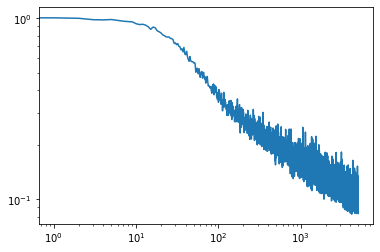

In [14]:
loglog(losses)

In [15]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [16]:
res, state = score(batch['x'],batch['s'], is_training=False)

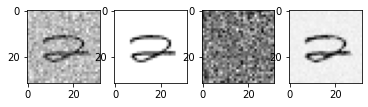

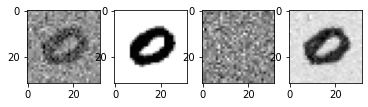

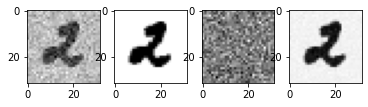

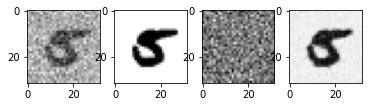

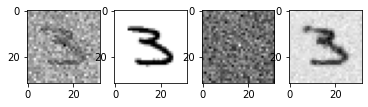

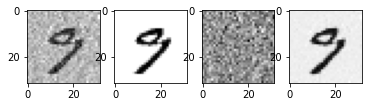

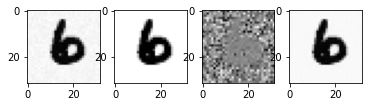

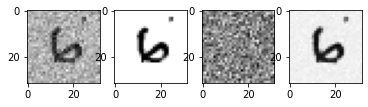

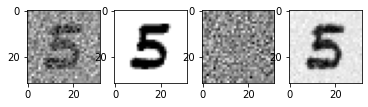

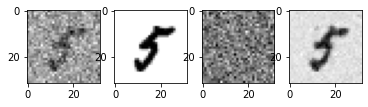

In [17]:
for i in range(10):
  ind = i
  figure()
  subplot(141)
  imshow(batch['x'][ind,...,0],cmap='gray_r')
  subplot(142)
  imshow(batch['y'][ind,...,0],cmap='gray_r')
  subplot(143)
  imshow(res[ind,...,0],cmap='gray_r')
  subplot(144)
  imshow(batch['x'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='gray_r')

In [18]:
# Trying to sample from the model
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

In [31]:
batch = get_batch()

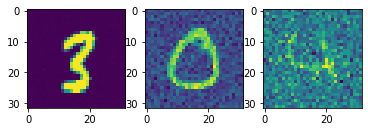

In [32]:
subplot(131)
imshow(batch['x'][0,...,0].reshape((32,32,)))
subplot(132)
imshow(batch['x'][1,...,0].reshape((32,32,)))
subplot(133)
imshow(batch['x'][2,...,0].reshape((32,32,)))

In [33]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax


def score_fn(x):
    return score(x.reshape((1,32,32,1)),jnp.zeros((1,1,1,1)), is_training=False)[0].reshape((32*32,))

In [34]:
num_results = int(1e4)
num_burnin_steps = int(1e2)

In [35]:
@jax.jit
def get_samples():
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=score_fn,
            num_leapfrog_steps=3,
            num_delta_logp_steps=4,
            step_size=0.002)
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= batch['x'][0,...,0].reshape((32*32,)),#0.5*randn(32,32).reshape((32*32,)).astype('float32'),#
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1))
    return samples_shmc, is_accepted_shmc 
 
samples_shmc, is_accepted_shmc = get_samples()

In [36]:
len(where(is_accepted_shmc)[0])

7669

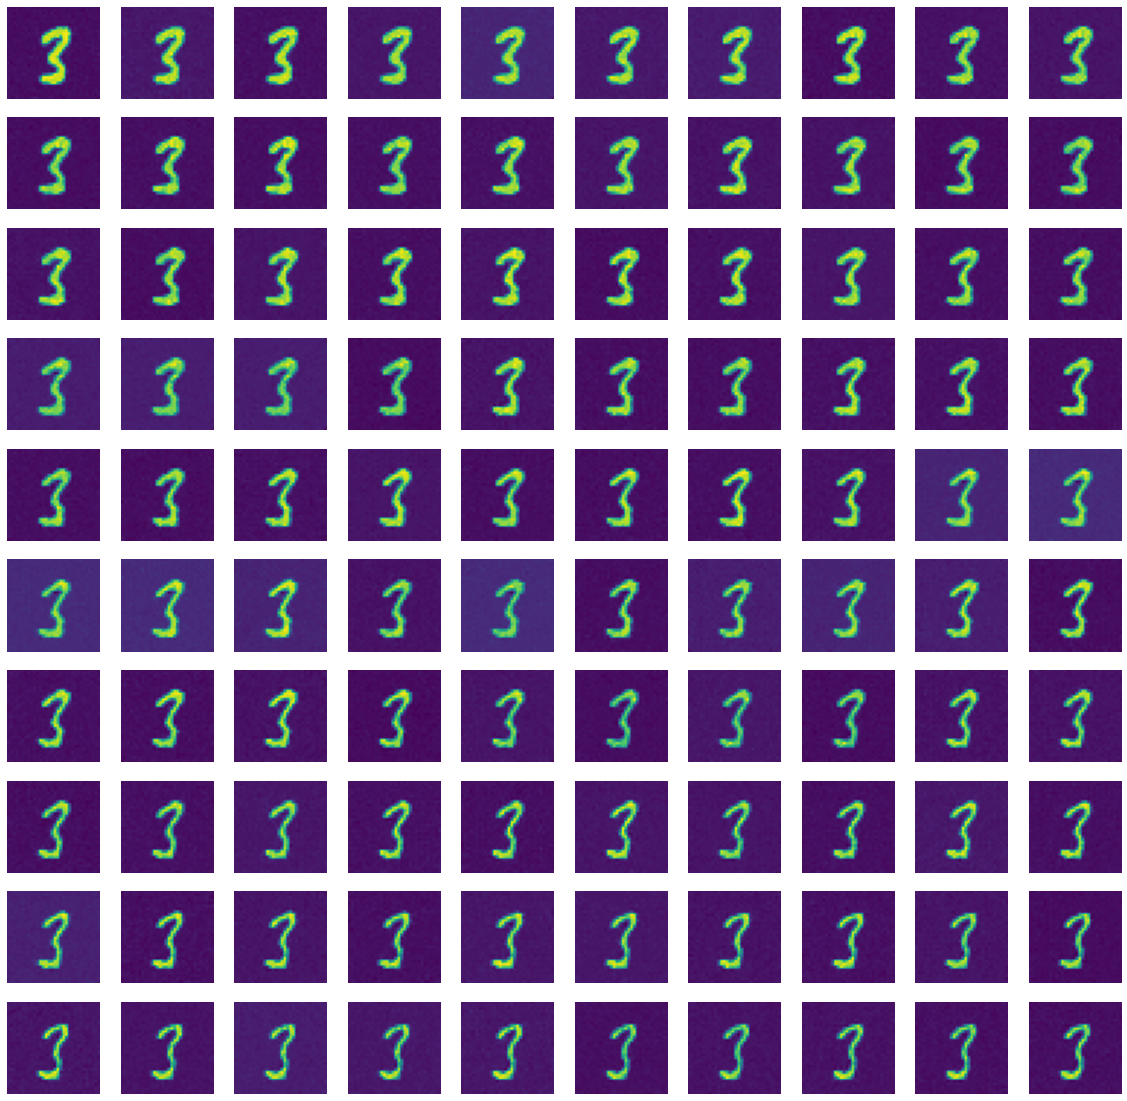

In [39]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

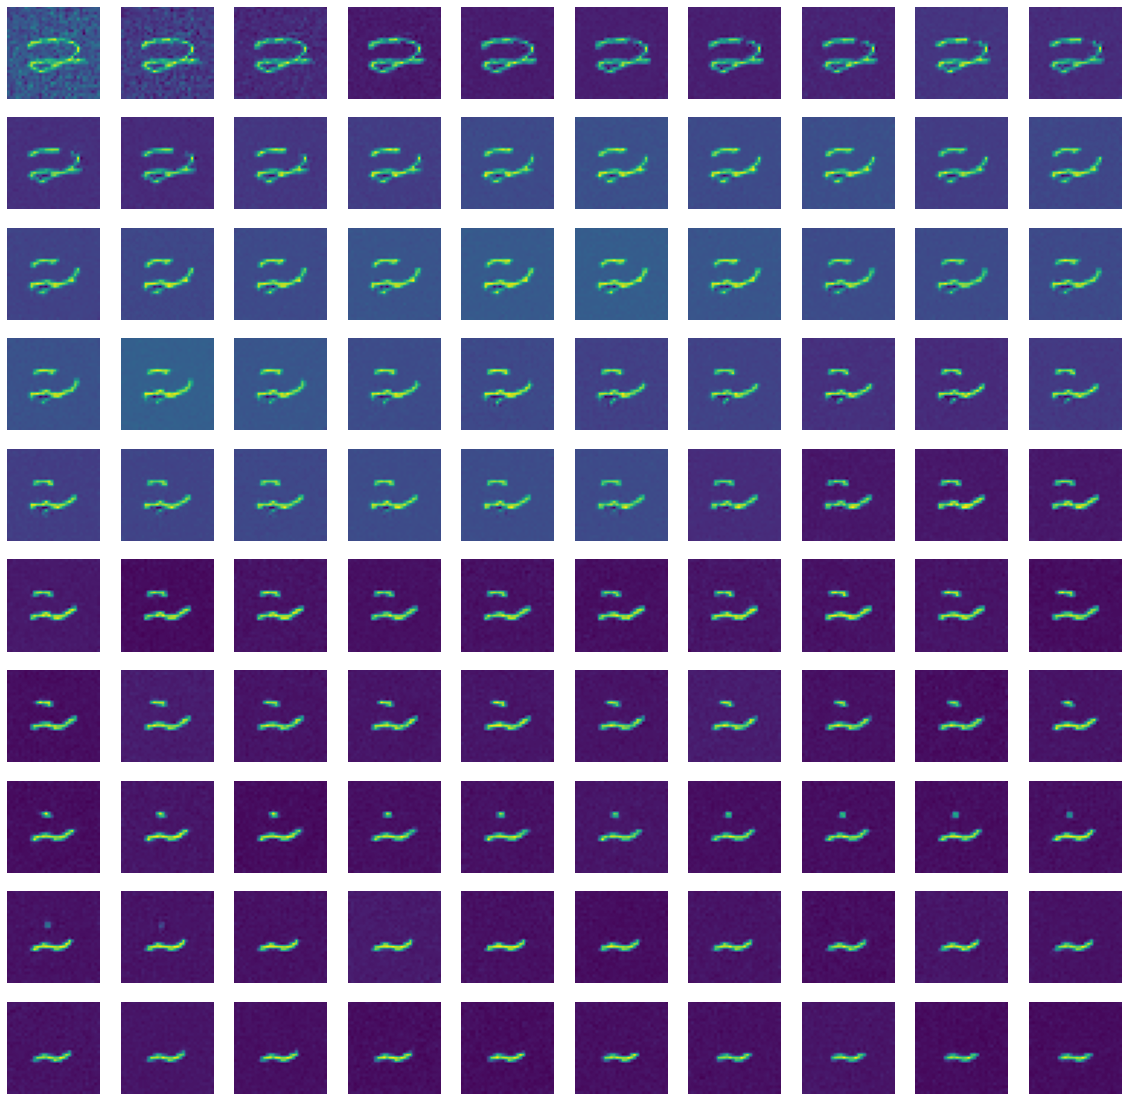

In [30]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')